### Import lib

In [1]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import transformers
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from PIL import Image
from torch.utils.data import DataLoader
import random
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
dir_path = Path("/kaggle/input/brain-tumor-mri-dataset")

# train_dir = dir_path/"train"
# test_dir = dir_path/"test"

#For kaggle
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

In [3]:
images = list(dir_path.glob("*/*/*.jpg"))
images[:10]

[PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg'),
 PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg')]

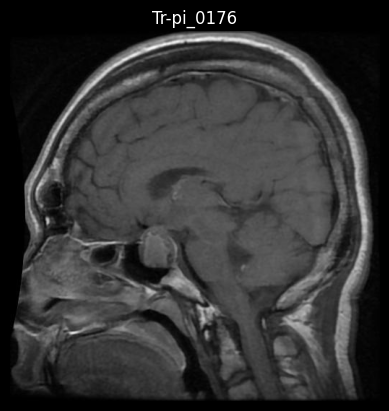

In [4]:
random_image = random.choice(images)
title = random_image.stem
img = Image.open(random_image)
plt.figure(facecolor="black")
plt.imshow(img)
plt.title(title,color="white")
plt.axis("off")
plt.show()

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

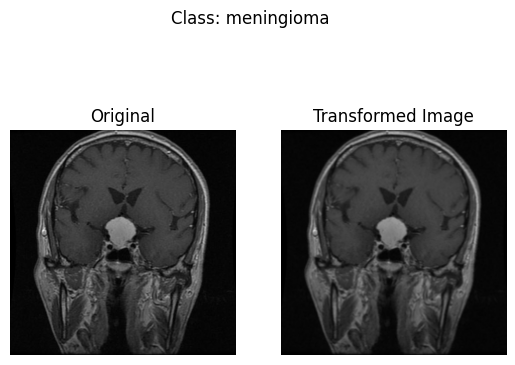

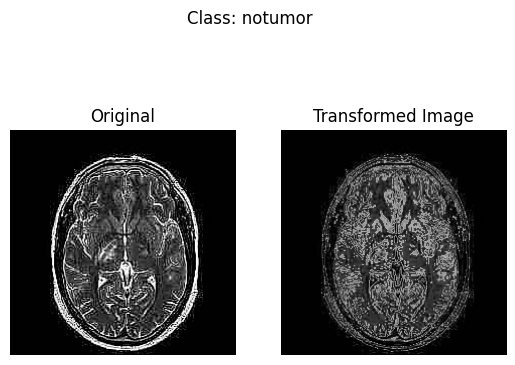

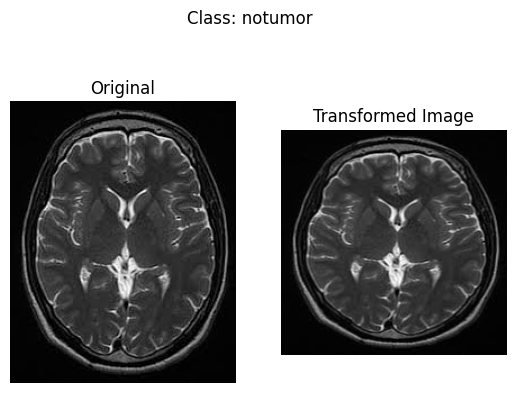

In [6]:
def plot_random(image_path_list,transform,n=3,seed=0):
    # sorted(image_path_list)
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path_list,k=n)

    for i in random_image_paths:
        # t = i.parent.stem
        with Image.open(i) as img:
            fig,ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(img)
            ax[0].set_title("Original")
            ax[0].axis("off")

            transform_img = transform(img)
            ax[1].imshow(transform_img.permute(1,2,0))
            ax[1].set_title("Transformed Image")
            ax[1].axis("off")

            fig.suptitle(f"Class: {i.parent.stem}")
    plt.show()


plot_random(images,data_transform,3)

In [7]:
def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))
    

train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transform, loader=safe_pil_loader)
test_dataset= datasets.ImageFolder(root=test_dir,transform=data_transform, loader=safe_pil_loader)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

len(train_dataset), len(test_dataset), len(train_dataloader), len(test_dataloader)

(5712, 1311, 179, 41)

### Resnet18 model 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 — Loss: 1.2698, Acc: 43.12%
Epoch 2/10 — Loss: 1.0087, Acc: 64.30%
Epoch 3/10 — Loss: 0.8679, Acc: 71.01%
Epoch 4/10 — Loss: 0.7911, Acc: 73.65%
Epoch 5/10 — Loss: 0.7302, Acc: 75.56%
Epoch 6/10 — Loss: 0.6922, Acc: 76.26%
Epoch 7/10 — Loss: 0.6617, Acc: 77.28%
Epoch 8/10 — Loss: 0.6449, Acc: 77.66%
Epoch 9/10 — Loss: 0.6281, Acc: 78.64%
Epoch 10/10 — Loss: 0.6007, Acc: 79.27%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.80      0.68      0.74       300
  meningioma       0.59      0.54      0.57       306
     notumor       0.84      0.90      0.87       405
   pituitary       0.77      0.87      0.82       300

    accuracy                           0.76      1311
   macro avg       0.75      0.75      0.75      1311
weighted avg       0.76      0.76      0.76      1311



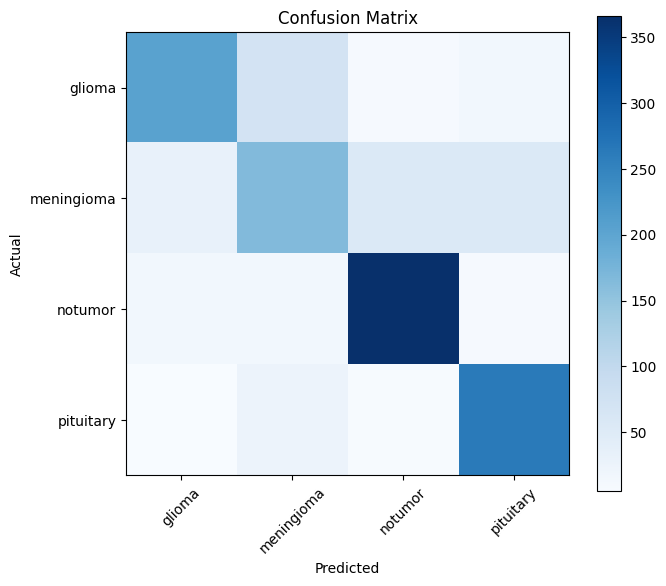

In [14]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

assert torch.cuda.device_count() >= 2, "Need at least 2 GPUs"
device = torch.device("cuda")

num_classes   = 4      
num_epochs    = 10
learning_rate = 1e-4

train_loader = train_dataloader
test_loader  = test_dataloader
class_names  = test_loader.dataset.classes

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

model = nn.DataParallel(model, device_ids=[0, 1])
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.module.fc.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total   = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss    = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = 100 * correct / total
    print(f"Epoch {epoch}/{num_epochs} — Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



In [26]:
torch.save(model.state_dict(),"/kaggle/working/ResNet.pth")

print("ResNet model saved successfully!")

ResNet model saved successfully!


                                   ====Predicting Using ResNet Model====
 
 


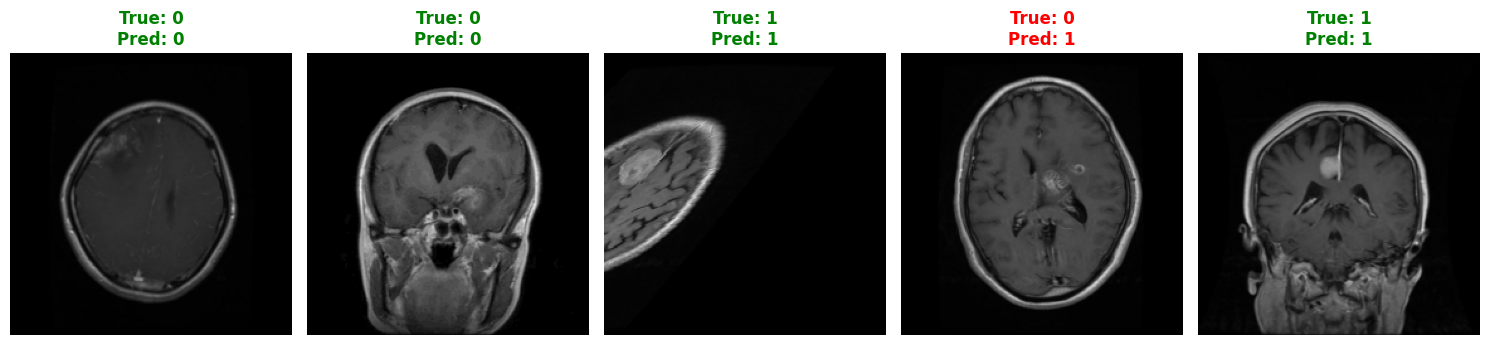

In [24]:
import random
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def get_random_test_samples(test_dataloader, num_samples=10):
    test_batch = next(iter(test_dataloader))
    test_images, test_labels = test_batch
    indices = random.sample(range(len(test_images)), min(num_samples, len(test_images)))
    imgs = test_images[indices]
    labels = test_labels[indices]
    resize = transforms.Resize((224, 224))
    imgs = torch.stack([resize(img) for img in imgs])
    return imgs, labels

model.eval()
device = next(model.parameters()).device

random_images, random_labels = get_random_test_samples(test_dataloader, num_samples=5)
random_images = random_images.to(device)

with torch.no_grad():
    logits = model(random_images)
    probs  = torch.softmax(logits, dim=1)
    preds  = torch.argmax(probs, dim=1)

random_images = random_images.cpu()
random_labels = random_labels.cpu()
preds = preds.cpu()

plt.figure(figsize=(15, 10))
for i, (img, true, pred) in enumerate(zip(random_images, random_labels, preds)):
    plt.subplot(1, 5, i+1)
    im = img.permute(1, 2, 0).numpy()
    if im.max() > 1.0:
        im = im / 255.0
    plt.imshow(im)
    correct = (true.item() == pred.item())
    color = 'green' if correct else 'red'
    plt.title(f"True: {true.item()}\nPred: {pred.item()}", color=color, fontweight='bold')
    if not correct:
        ax = plt.gca()
        for side in ['top','bottom','left','right']:
            ax.spines[side].set_color('red')
            ax.spines[side].set_linewidth(3)
    plt.axis('off')

plt.tight_layout()
print("                                   ====Predicting Using ResNet Model====")
print(" ")
print(" ")
plt.show()
_ = get_random_test_samples(test_dataloader, num_samples=10)
